## Iteration 기능과 사람의 개입(human in the loop)

`iter()` 메서드는 에이전트의 실행 과정을 단계별로 반복할 수 있게 해주는 반복기능(Iterator)를 생성한다.

중간과정에서 사용자의 입력을 받아 계속 진행할지 묻는 기능을 제공하고, 이를 `Human-in-the-loop`라고 한다.

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_teddynote import logging

logging.langsmith("agent-iter")

LangSmith 추적을 시작합니다.
[프로젝트명]
agent-iter


In [6]:
from langchain.agents import tool

# 도구 정의
@tool 
def add_function(a: float, b: float) -> float:
    """Add two numbers together."""
    return a + b



다음은 `add_function` 을 사용하여 덧셈 계산을 수행하는 Agent 를 정의한다.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
# Define tools
tools = [add_function]

# create LLM
# gpt = ChatOpenAI(model="gpt-4o-mini", temperature=0)
ollama = ChatOllama(model="llama3.1", temperature=0)

# create prompt
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant."
    ),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# create agent
# gpt_agent = create_tool_calling_agent(gpt, tools, prompt)
ollama_agent = create_tool_calling_agent(ollama, tools, prompt)

# create AgentExecutor 
agent_executor = AgentExecutor(
    agent= ollama_agent,
    # agent= gpt_agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    handle_parsing_errors=True
)

### AgentExecutor의 iter() 메서드 사용

이 메서드는 AgentExecutor의 실행 과정을 단계별로 반복할 수 있게 해주는 반복기능(iterator)를 생성한다. 

**함수설명** `iter()`는 에이전트가 최종 출력에 도달하기까지 거치는 단계들을 순차적으로 접근할 수 있는 `AgentExecutorIterator` 객체를 반환한다.

이는 에이전트의 실행과정을 단계별로 살펴볼수 있다.

- Flow
    "114.5 + 121.2 + 34.2 + 110.1" 의 덧셈 계산을 수행하기 위해서는 단계별로 계산이 수행되게 된다.
    1. 114.5 + 121.2 = 235.7
    2. 235.7 + 34.2 = 270.9
    3. 270.9 + 110.1 = 381.0
이러한 계산 과정을 단계별로 살펴볼 수 있다.

이때,

단계별로 계산 결과를 사용자에게 보여주고, 사용자가 계속 진행할지 묻는다. (Human-in-the-loop)

사용자가 'y'가 아닌 다른 입력을 하면 반복 중단된다

In [11]:
# 계산할 질문 설정
question = "114.5 + 121.2 + 34.2 + 110.1 "

# agent_executor를 반복적으로 실행
for step in agent_executor.iter({"input": question}):
    if output := step.get("intermediate_step"):
        action, value = output[0]
        if action.tool == "add_function":
            # Tool 실행 결과 출력
            print(f"\nTool Name: {action.tool}, 실행 결과: {value}")
        # 사용자에게 계속 진행할지 묻습니다.
        _continue = input("계속 진행하시겠습니다? (y/n)?:\n") or "Y"
        # 사용자가 'y'가 아닌 다른 입력을 하면 반복 중단
        if _continue.lower() != "y":
            break

# 최종 결과 출력
if "output" in step:
    print(step["output"])





> Entering new None chain...

Invoking: `add_function` with `{'a': 114.5, 'b': 121.2}`


235.7
Invoking: `add_function` with `{'a': 34.2, 'b': 110.1}`


144.3
Tool Name: add_function, 실행 결과: 235.7
The final answer is: 235.7 + 144.3 = 380.0

> Finished chain.
The final answer is: 235.7 + 144.3 = 380.0


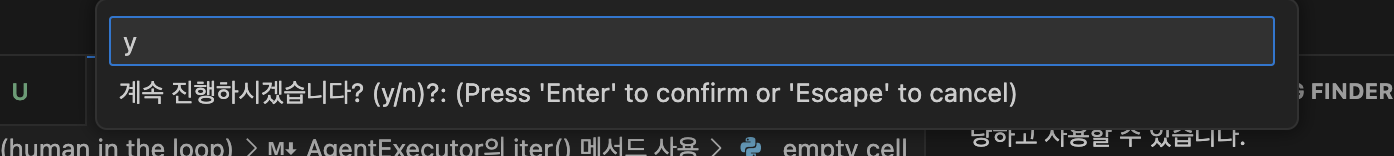

덧셈 계산 중간 human이 개입하여 계산을 계속 진행할지 묻는 과정을 볼 수 있다.